In [1]:
import numpy as np
import pandas as pd
import numba
import scipy.integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from RD_network_functions import state_plotter

import matplotlib.pyplot as plt

import biocircuits
import bokeh.io
import bokeh.plotting

import panel as pn
pn.extension()

import math

from RD_network_functions import *
from itertools import permutations


In [2]:
# test one network topology
ID = '/Users/jiwang/workspace/imp/organoid_patterning/results/RD_topology_test/3N_testExample_python'

n = 3 # nb of node
k_length = 15 # nb of reaction parameters

states = 0 # steady state
turing = 0 # patterning 

# define ODE model without diffusion
def f_ode(x, t, k):
    #dRdt = np.empty(n)
    
    ## the test example from Zheng et al, 2016, Fig.S1A
    dx0dt = 55.14*x[2]**2/(18.48**2 + x[2]**2) + 0.1 - 1.341*x[0]
    dx1dt = 29.28*x[2]**2/(15.90**2 + x[2]**2) + 0.1 - 0.3508*x[1]
    dx2dt = 16.17*x[0]**2/(x[0]**2 + 0.6421**2)*1.316**2/(1.316**2 + x[1]**2) + 0.1 - 1.203*x[2]
    
    ## the test example from Zheng et al, 2016, Fig.S1B (something not right in the formula)
    #dx0dt = 50.86*x[0]**2/(x[0]**2 + 0.02315**2)*17.64**2/(17.64**2 + x[1]**2) + 0.1 - 0.09367*x[0]
    #dx0dt = 50.86*(x[0]**2/(x[0]**2 + 0.02315**2) * x[1]**2/(17.64**2 + x[1]**2)) + 0.1 - 0.09367*x[0]
    #dx1dt = 17.43*x[0]**2/(x[0]**2 + 5.230**2)*1.038**2/(1.038**2 + x[2]**2) + 0.1 - 2.699*x[1]
    #dx1dt = 17.43*(5.230**2/(x[0]**2 + 5.230**2) * 1.038**2/(1.038**2 + x[2]**2)) + 0.1 - 2.699*x[1]
    #dx2dt = 69.57*x[2]**2/(x[2]**2 + 1.000**2)*0.02100**2/(0.02100**2 + x[1]**2) + 0.1 - 0.1503*x[2]
    
    #dx0dt = k[0]*(1.0/(1.0 + pow(k[9]/x[0], 2))*1.0/(1.0 + pow(x[1]/k[10], 2))) + k[3] - k[6]*x[0]
    #dx1dt = k[1]*(1.0/(1.0 + pow(k[11]/x[0], 2)) + 1.0/(1.0 + pow(k[12]/x[2], 2))) + k[4] - k[7]*x[1]
    #dx2dt = k[2]*(1.0/(1.0 + pow(k[13]/x[0], 2))*1.0/(1.0 + pow(x[1]/k[14], 2))) + k[5] - k[8]*x[2]
    
    dRdt = [dx0dt, dx1dt, dx2dt]
    
    return dRdt

In [3]:
k = np.ones(k_length)
k[0], k[1], k[2] = 10, 10, 20 
k[3], k[4], k[5] = 5, 5, 10
#k[6], k[7], k[8] = math.log(2)/10, math.log(2)/5, math.log(2)/10
k[6], k[7], k[8] = 0.1, 1, 0.1
k[9], k[10], k[11], k[12], k[13], k[14] = 30, 50, 50, 70, 40, 80

k 

binary_diffusor = [0, 1, 1]
d = [0, 2, 0.5]

# define initial conditions for ODE
x_max = 20001
x_int = 10000
c_init = permutations([1, x_int, x_max]) 

for i in list(c_init): 
    print (i) 


(1, 10000, 20001)
(1, 20001, 10000)
(10000, 1, 20001)
(10000, 20001, 1)
(20001, 1, 10000)
(20001, 10000, 1)


array([0.70187119, 1.9960234 , 2.30016458])

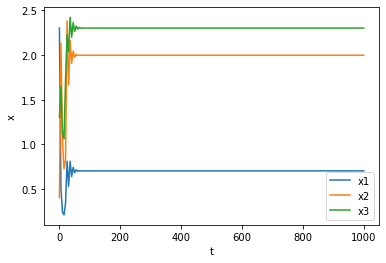

In [4]:
x0 = np.random.random(1) * np.ones(n)
x0 = [2.3, 0.4, 1.3]
err_tole = 0.0000001

t_final = 1000
t = np.linspace(0, t_final, 200)
sol = odeint(f_ode, x0, t, args=(k,))

## check the integration solution
fig,ax = plt.subplots()
ax.plot(t,sol[:,0],label='x1')
ax.plot(t,sol[:,1],label='x2')
ax.plot(t,sol[:,2],label='x3')
#ax.plot(t,result[:,2],label='R0=1')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')

sol[199, ]

In [5]:
ss = np.zeros(n)
ss_fluc = np.zeros(n)
nb_passThreshold = 0

for i in range(n):
    ss[i] = np.mean(sol[100:149, i])
    ss_fluc[i] = np.abs(np.mean(sol[150:199, i]) - np.mean(sol[100:149, i]))
    if ss_fluc[i] >= err_tole:
        nb_passThreshold = nb_passThreshold + 1
ss

array([0.70187119, 1.9960234 , 2.30016458])

In [6]:
import sympy as sym
X = sym.symbols(('x0:3'))
K = sym.symbols(('k0:15'))
X, K

((x0, x1, x2),
 (k0, k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14))

In [7]:
f_sym = sym.Matrix(f_ode(X, None, K))
J = f_sym.jacobian(X)
J_func = sym.lambdify((X, K),  J)

#J_inputs = J.free_symbols
S = J_func(ss, k)
w  =  np.linalg.eigvals(S)
max(w), S

((-0.1126056501869701+0.5915044708904216j),
 array([[-1.341     ,  0.        ,  0.72027531],
        [ 0.        , -0.3508    ,  0.51118214],
        [ 3.46265186, -1.86270896, -1.203     ]]))

In [8]:
f_sym

Matrix([
[                            -1.341*x0 + 55.14*x2**2/(x2**2 + 341.5104) + 0.1],
[                             -0.3508*x1 + 29.28*x2**2/(x2**2 + 252.81) + 0.1],
[28.00411152*x0**2/((x0**2 + 0.41229241)*(x1**2 + 1.731856)) - 1.203*x2 + 0.1]])

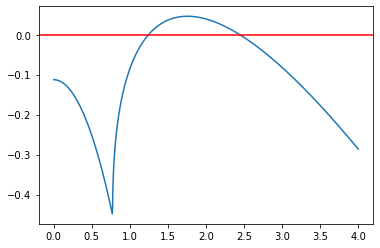

0.04615745131800178

In [10]:
diffusing_nodes = binary_diffusor

d = [0.07018, 1, 0.01057]
#d = [1.00, 1.303, 0]
q = np.linspace(0, 4, 1000)
lam_real = np.empty_like(q)
lam_im = np.empty_like(q)

for j in range(len(q)):
    #j = 1
    S2 = S - np.diag(np.multiply(d, q[j]**2))
    #wk,vk =  np.linalg.eig(S2)
    wk = np.linalg.eigvals(S2)
    lam_real[j] = wk.real.max()
    lam_im[j] = wk.imag[np.argmax(wk.real)]
    
plt.plot(q, lam_real)
#plt.axis([0, max(q), -1, 1])
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

max(lam_real)

In [11]:
S, S2

(array([[-1.341     ,  0.        ,  0.72027531],
        [ 0.        , -0.3508    ,  0.51118214],
        [ 3.46265186, -1.86270896, -1.203     ]]),
 array([[ -2.46388   ,   0.        ,   0.72027531],
        [  0.        , -16.3508    ,   0.51118214],
        [  3.46265186,  -1.86270896,  -1.37212   ]]))

In [11]:
index_max = np.argmax(lam_real) 
lam_real_max = lam_real[index_max]
lam_im_max = lam_im[index_max]
q_max = q[index_max]

In [12]:
q_max, 2*3.1415/q_max

(1.7537537537537538, 3.5826010273972604)

From here is the numerical solution of RD PDE

In [14]:
from RD_network_functions import *

# constant diffusion coeffients
def constant_diff_coeffs(c_tuple, t, x, diff_coeffs):
    n = len(c_tuple[0])
    return tuple([diff_coeffs[i] * np.ones(n) for i in range(len(c_tuple))])


# deinfe the reaction equations
def asdm_rxn(as_tuple, t, mu):
    """
    Reaction expression for activator-substrate depletion model.

    Returns the rate of production of activator and substrate, respectively.

    r_a = a**2 * s - a
    r_s = mu * (1 - a**2 * s)
    """
    # Unpack concentrations
    a, s = as_tuple

    # Compute and return reaction rates
    a2s = a ** 2 * s
    return (a2s - a, mu * (1.0 - a2s))


In [18]:
# Set up intial condition (using 500 grid points)
a_0 = np.ones(500)
s_0 = np.ones(500)
a_0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [23]:
# Make a small perturbation to a_0 by adding noise
a_0 += 0.001 * np.random.rand(len(a_0))

In [24]:
# Time points
t = np.linspace(0.0, 1000.0, 100)

# Physical length of system
L = 20.0

In [25]:
# x-coordinates for plotting
x = np.linspace(0, L, len(a_0))

# Diffusion coefficients
diff_coeffs = (0.05, 1.0)

# Reaction parameter (must be a tuple of params, even though only 1 for ASDM)
rxn_params = (1.5,)

In [40]:
test = [0, 1, 2, 3];
test[-1]

3

In [39]:
# Solve
conc = rd_solve(
    (a_0, s_0),
    t,
    L=L,
    derivs_0=0,
    derivs_L=0,
    periodic_boundary = True,
    diff_coeff_fun=constant_diff_coeffs,
    diff_coeff_params=(diff_coeffs,),
    rxn_fun=asdm_rxn,
    rxn_params=rxn_params,
)


TypeError: rd_solve() got an unexpected keyword argument 'periodic_boundary'

500
100


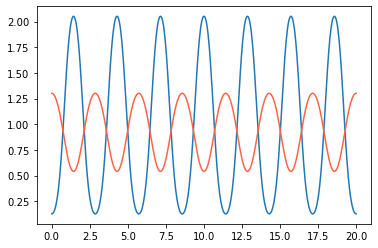

In [38]:
t_point = 1000000
i = np.searchsorted(t, t_point)
i = 98

plt.plot(x, conc[0][i, :])
plt.plot(x, conc[1][i, :],
        color="tomato"
    )

print(len(x));

print(len(conc[0]))

In [16]:
import numpy as np
import pandas as pd
import numba
import scipy.integrate
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import biocircuits
import bokeh.io
import bokeh.plotting

import panel as pn
pn.extension()


t_slider = pn.widgets.FloatSlider(
     name="t", start=t[0], end=t[-1], value=t[-1], step=t[1] - t[0]
 )

@pn.depends(t_slider)
def plot_turing(t_point):
    i = np.searchsorted(t, t_point)

    p = bokeh.plotting.figure(
        frame_width=400,
        frame_height=200,
        x_axis_label="x",
        y_axis_label="a, s",
        x_range=[0, L],
        y_range=[0, np.concatenate(conc).max()*1.02],
    )

    p.line(x, conc[0][i, :], legend_label="activator", line_width=2)
    p.line(
        x,
        conc[1][i, :],
        color="tomato",
        legend_label="substrate",
        line_width=2,
    )

    return p

pn.Column(t_slider, plot_turing)

Column
    [0] FloatSlider(end=1000.0, name='t', step=10.1010101010101, value=1000.0)
    [1] ParamFunction(function)

### 2D numerical solution

In [17]:
import rdsolver
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
notebook_url = 'localhost:8888'

# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = (32, 32)
L = (50, 50)

t = np.linspace(0, 100000, 100)

# Initial condition and solve
c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)

# Interpolate the solution
c_interp = rdsolver.viz.interpolate_concs(c)

100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


In [18]:
bokeh.io.show(rdsolver.viz.display_single_frame(c_interp, i = -1, frame_height=300))

In [17]:
c0
?rdsolver.solve
